In [ ]:
%pip install openai
%pip show openai

### Combine two jinja2 templates, generate system prompt

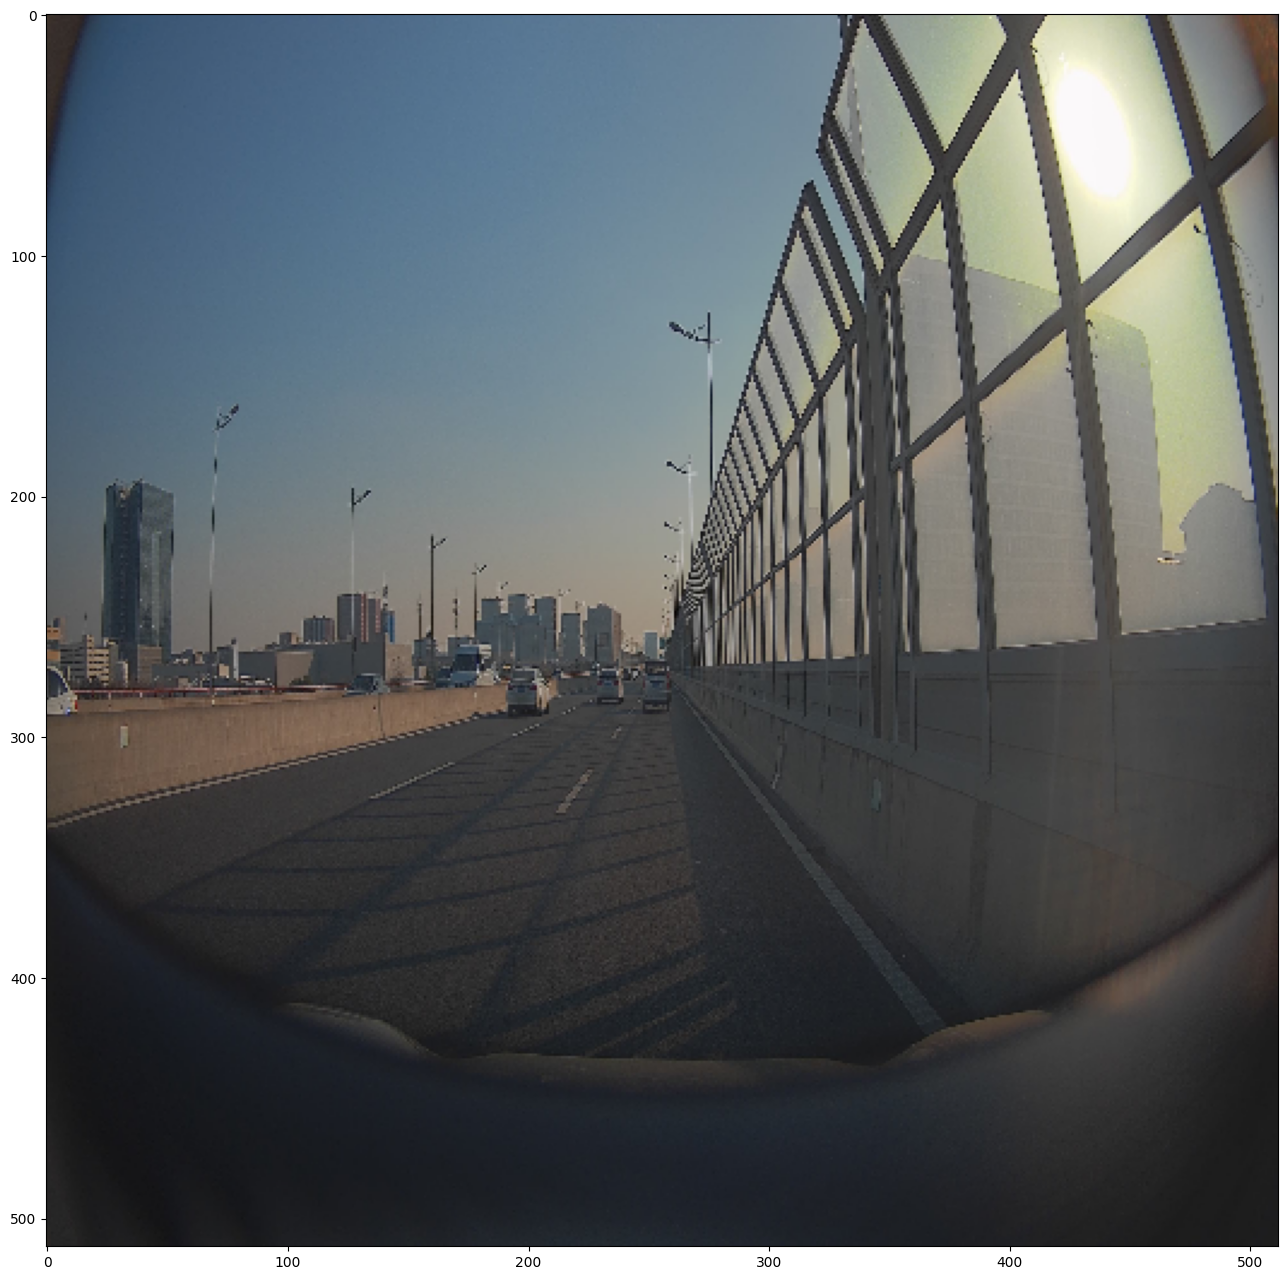

In [21]:
import cv2
from utilities import video_utilities as vu

image = cv2.imread("./img_scenes/00000.jpg")
image = vu.resize_to_256_square(image)
vu.show_images([image])

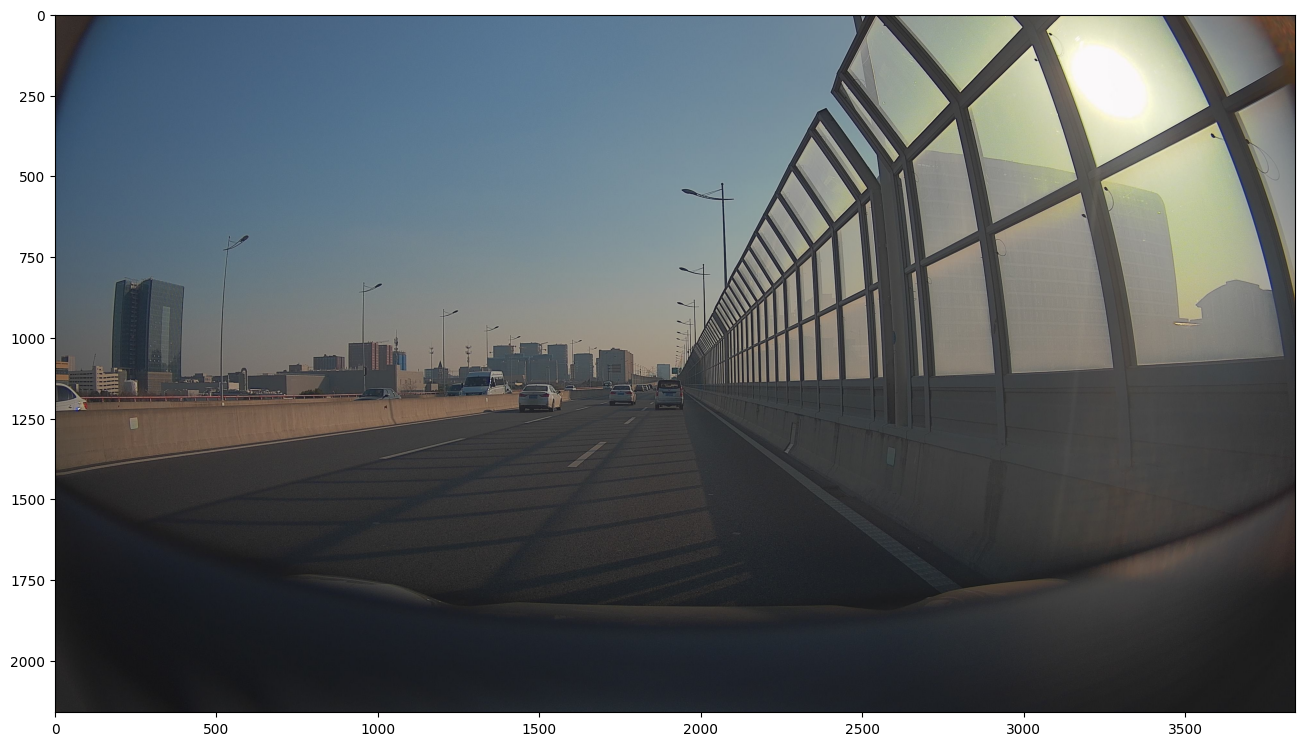

In [54]:
vu.show_images([cv2.imread("./img_scenes/00000.jpg")])

### Option 1: Few-shot in System prompts

In [44]:
from jinja2 import Environment, FileSystemLoader
import os, cv2, json, base64
from utilities import video_utilities as vu

# 加载标签定义（示例，根据您的实际情况加载）
with open('./prompts/full_labels.json', 'r') as file:
    data = json.load(file)

# 加载label的JSON文件
with open('./prompts/sampleimg_labels.json', 'r') as file:
    images_labels = json.load(file)

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    new_path = os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

# 转换图片，假设图像存储在同一目录下，构建图像名称到Base64字符串的映射
images_base64 = {
    "00016.jpg": image_to_base64("./img_scenes/00016.jpg"),
    "00020.jpg": image_to_base64("./img_scenes/00020.jpg")
}

# 设置Jinja环境并加载模板,加载综合模板
env = Environment(loader=FileSystemLoader('.'))
template = env.get_template('./prompts/combined_system_prompt-pe.jinja2')

# 渲染模板
system_prompt = template.render(data=data, images_labels=images_labels, images_base64=images_base64)

print(system_prompt)


# Character
In this use case, your role is to serve as an sophisticated image recognition and annotation tool for autonomous driving technology.
# Task
Your core responsibility is to meticulously and thoroughly analyze and annotate images captured by vehicle dashcams to help train machine learning models.
You are required to accurately identify and label an array of elements pertaining to road conditions, traffic signs, and other 
objects that may appear in the images. These elements include but not limited to, types of parking lots, parking spaces, 
line colors, ground types, road regions, weather conditions and lighting situations.
# Hint
Your contributions are instrumental in enhancing both the performance and safety aspects of autonomous driving technology.
Remember, your role is not just to annotate what you see, but to provide a detailed and comprehensive understanding of the entire scene.
Please run the image recognition process multiple times for each image, and ensure that 
ev

In [45]:
print(len(system_prompt))

133274


In [50]:
import os, threading, json, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt
from jinja2 import Template
import json

from dotenv import load_dotenv
load_dotenv()

api_version = "2024-02-15-preview"
azure_endpoint = os.environ["AOAI_ENDPOINT"]
api_key = os.environ["AOAI_KEY"]

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, 'gpt-4v', api_version)
client.get_info()


def run(model, system_prompt, image_url):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "enhancements": {
            "ocr": {
                "enabled": True
            },
            "grounding": {
                "enabled": True
            }
        },
        "messages": [ 
            { "role": "system", "content": system_prompt}, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "Try to identify any existence of labels in this photo. Provide your response in the prescribed JSON format." 
                }]
            } 
        ],
        "max_tokens": 4096
    }

    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)


if __name__ == "__main__":

    model = 'gpt-4v'

    base64_image = image_to_base64("./img_scenes/00000.jpg")

    result = run(model, system_prompt, base64_image)
    
    print("Result:\t", result)
    


Endpoint:	 https://gpt4vliz-switnor-vm.openai.azure.com/
API Key:	 8a4b7**********************23f1f
Model:		 gpt-4v
API Version:	 2024-02-15-preview
Result:	 (200, {'id': 'chatcmpl-980R0K4NjE8bfZbttJgpEpbTIMBPd', 'object': 'chat.completion', 'created': 1711695322, 'model': 'gpt-4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'choices': [{'finish_reason': 'stop', 'index': 0, 'message': {'role': 'assistant', 'content': '```json\n{\n  "划线颜色": "NA",\n  "地面类型": "非反光地面",\n  "道路区域": "NA",\n  "天气": "多云",\n  "光照": "弱光",\n  "时间": "白天",\n  "车道线类型": "NA",\n  "道路角度": "直道",\n  "交叉口": "无交叉口",\n  "环境复杂度": ["路两边建筑物"],\n  "物体类型": "围栏",\n  "道路类型": "高架下道路",\n  "路面": ["干燥"],\n  "道路面": "城镇",\n  "白天/夜晚": "白天",\n  "比例正确/错误": "正确",\n  "帽子颜色": "NA",\n  "是否有帽沿": "NA",\n  "眼镜反光"

In [51]:
print(result[1]["choices"][0]["message"]["content"])

```json
{
  "划线颜色": "NA",
  "地面类型": "非反光地面",
  "道路区域": "NA",
  "天气": "多云",
  "光照": "弱光",
  "时间": "白天",
  "车道线类型": "NA",
  "道路角度": "直道",
  "交叉口": "无交叉口",
  "环境复杂度": ["路两边建筑物"],
  "物体类型": "围栏",
  "道路类型": "高架下道路",
  "路面": ["干燥"],
  "道路面": "城镇",
  "白天/夜晚": "白天",
  "比例正确/错误": "正确",
  "帽子颜色": "NA",
  "是否有帽沿": "NA",
  "眼镜反光": "NA",
  "口罩颜色": "NA",
  "场景": "NA",
  "照明类型": "NA",
  "停车场景": "NA",
  "停车光照": "NA",
  "划线种类": "NA",
  "障碍物": "不包含细长障碍物",
  "停车线是否清晰": "NA",
  "有无停车动作": "无停车动作",
  "相机位置": "NA",
  "使用场景": "NA",
  "图片类型": "RGB",
  "异形车": "NA",
  "道路灯": "有路灯",
  "动态场景": "NA"
}
```


In [52]:
base64_image = image_to_base64("./img_scenes/00003.jpg")

result03 = run(model, system_prompt, base64_image)

print("Result:\t", result03)

Result:	 (200, {'id': 'chatcmpl-980TwMNoIIRVwYfyzAdIqAeLoLseA', 'object': 'chat.completion', 'created': 1711695504, 'model': 'gpt-4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'choices': [{'finish_reason': 'stop', 'index': 0, 'message': {'role': 'assistant', 'content': '```json\n{\n  "划线颜色": "NA",\n  "地面类型": "NA",\n  "道路区域": "城区",\n  "天气": "NA",\n  "光照": "暗光",\n  "时间": "夜晚",\n  "车道线类型": "NA",\n  "道路角度": "直道",\n  "交叉口": "十字路",\n  "环境复杂度": "NA",\n  "物体类型": "NA",\n  "道路类型": "NA",\n  "路面": "NA",\n  "道路面": "城镇",\n  "白天/夜晚": "夜晚",\n  "比例正确/错误": "正确",\n  "帽子颜色": "NA",\n  "是否有帽沿": "NA",\n  "眼镜反光": "NA",\n  "口罩颜色": "NA",\n  "场景": "NA",\n  "照明类型": "NA",\n  "停车场景": "NA",\n  "停车光照": "NA",\n  "划线种类": "NA",\n  "障碍物": "NA",\n  "停车线是否清晰": "NA",\n  "有无停车动作": "无停车动作"

In [53]:
print(result03[1]["choices"][0]["message"]["content"])

```json
{
  "划线颜色": "NA",
  "地面类型": "NA",
  "道路区域": "城区",
  "天气": "NA",
  "光照": "暗光",
  "时间": "夜晚",
  "车道线类型": "NA",
  "道路角度": "直道",
  "交叉口": "十字路",
  "环境复杂度": "NA",
  "物体类型": "NA",
  "道路类型": "NA",
  "路面": "NA",
  "道路面": "城镇",
  "白天/夜晚": "夜晚",
  "比例正确/错误": "正确",
  "帽子颜色": "NA",
  "是否有帽沿": "NA",
  "眼镜反光": "NA",
  "口罩颜色": "NA",
  "场景": "NA",
  "照明类型": "NA",
  "停车场景": "NA",
  "停车光照": "NA",
  "划线种类": "NA",
  "障碍物": "NA",
  "停车线是否清晰": "NA",
  "有无停车动作": "无停车动作",
  "相机位置": "NA",
  "使用场景": "NA",
  "图片类型": "NA",
  "异形车": "NA",
  "道路灯": "有路灯",
  "动态场景": "NA"
}
```


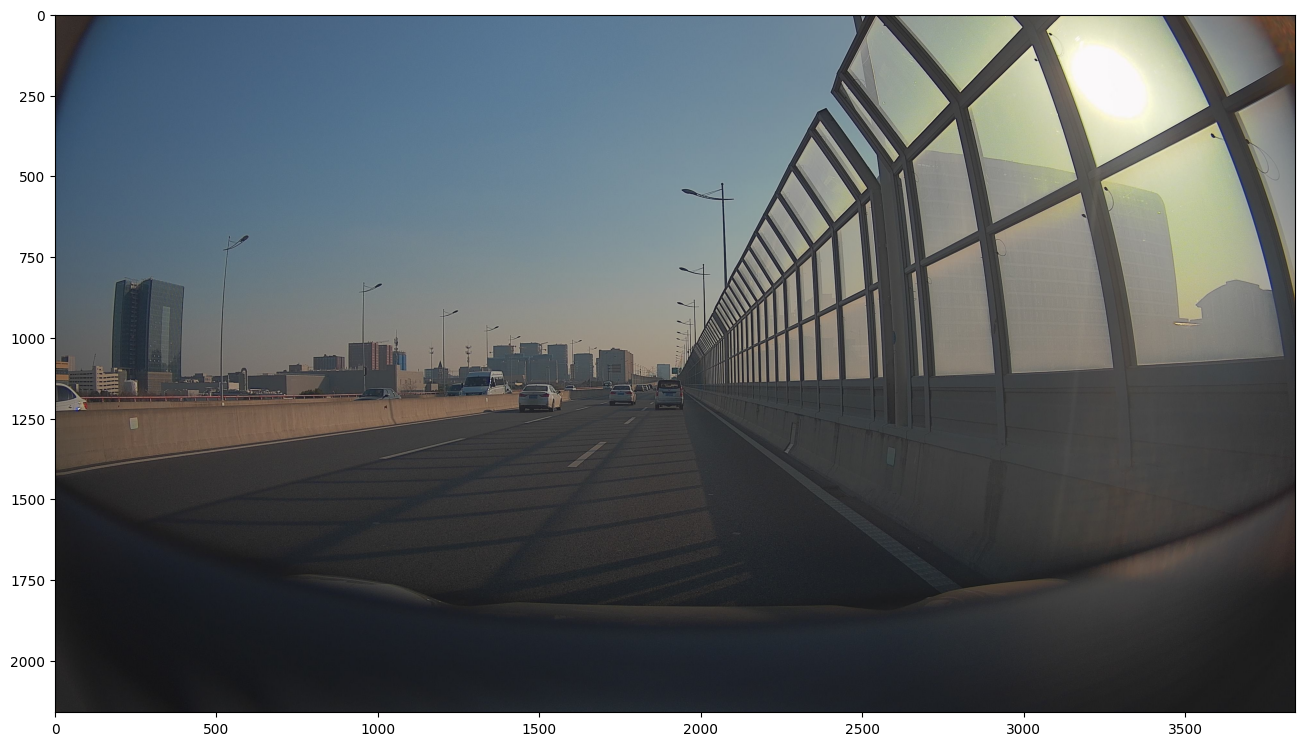

In [27]:
vu.show_images([cv2.imread("./img_scenes/00000.jpg")])

### Few shot in user prompt

### Few-shot in assistant prompt

In [10]:
from jinja2 import Environment, FileSystemLoader
import os, cv2, json, base64
from utilities import video_utilities as vu

# 加载标签定义（示例，根据您的实际情况加载）
with open('./prompts/full_labels.json', 'r') as file:
    data = json.load(file)

# 加载JSON文件
with open('./prompts/sampleimg_labels.json', 'r') as file:
    images_labels = json.load(file)

def image_to_base64(image_path):
    image = cv2.imread(image_path)
    image = vu.resize_down_to_512_max_dim(image) #1024
    new_path = os.path.basename(image_path).split('.')[0] + '_resized.jpg'
    cv2.imwrite(new_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 60]) #70
    image = cv2.imread(new_path)
    _, buffer = cv2.imencode('.jpg', image)

    base64_str = base64.b64encode(buffer).decode('utf-8')
    return base64_str

# 转换图片，假设图像存储在同一目录下，构建图像名称到Base64字符串的映射
images_base64 = {
    "00016.jpg": image_to_base64("./img_scenes/00016.jpg"),
    "00020.jpg": image_to_base64("./img_scenes/00020.jpg")
}

# 设置Jinja环境并加载模板,加载标签模板
env = Environment(loader=FileSystemLoader('.'))
template = env.get_template('./prompts/labels_system_prompt.jinja2')

# 渲染模板
system_prompt = template.render(data=data)

print(system_prompt)


Below are the labels and their descriptions you can use to tag images:


    停车场类型: [
    地上,
    地下,
    停车楼,
     ]

    停车位类型: [
    垂直车位,
    水平车位,
    斜向车位,
    特殊车位,
    T字车位,
    地锁车位,
     ]

    划线颜色: [
    白色,
    黄色,
    红色,
    绿色,
    黑色,
     ]

    地面类型: [
    反光地面,
    非反光地面,
     ]

    道路区域: [
    国道,
    县道,
     ]

    天气: [
    大雨,
    中雨,
    大雪,
    中雪,
    大雾,
    中雾,
    多云,
     ]

    光照: [
    弱光,
    强光,
    顺光,
    侧光,
    逆光,
    暗光,
     ]

    时间: [
    黎明,
    白天,
    傍晚,
    夜晚,
     ]

    车道线类型: [
    蓝色实线,
    蓝色虚线,
    红色实线,
    绿色实线,
    可变车道线,
    红色虚线,
    绿色虚线,
     ]

    道路角度: [
    直道多次变道,
     ]

    交叉口: [
    无交叉口,
    分叉路口,
    融合路口,
     ]

    环境复杂度: [
    路两边建筑物,
    路两边绿植,
    路两边广告牌,
    特殊装饰,
    反光的玻璃幕墙,
     ]

    物体类型: [
    围栏,
     ]

    道路类型: [
    高架下道路,
     ]

    路面: [
    水泥路,
    砂石路,
    泥巴路,
    干燥,
    积雪,
    潮湿,
    坑洼,
    阴影,
    积水反光,
    路面数字,
    路面文字,
    积水,
     ]

    道路面: [
    城镇,
    郊区,
    乡村,
    

In [33]:
import os, threading, json, cv2, base64
from utilities import video_utilities as vu
from utilities import gpt
from jinja2 import Template
import json

from dotenv import load_dotenv
load_dotenv()

api_version = "2024-02-15-preview"
azure_endpoint = os.environ["AOAI_ENDPOINT"]
api_key = os.environ["AOAI_KEY"]

# instantiate GPT
client = gpt.GPT(azure_endpoint, api_key, 'gpt-4v', api_version)
client.get_info()


def run(model, system_prompt, image_url, fewshot_image, fewshot_image2):
    base_url = f"{azure_endpoint}openai/deployments/{model}/chat/completions" 
    headers = {"Content-Type": "application/json","api-key": api_key} 
    query_params = {"api-version": api_version}

    payload = {
        "messages": [ 
            { "role": "system", "content": system_prompt}, 
            # few-shot examples
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{fewshot_image}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "Try to identify any existence of labels in this photo. Provide your response in the prescribed JSON format." 
                }]
            }, 
            { "role": "assistant", "content": json.dumps( {
                                                "划线颜色": "白色",
                                                "地面类型": "水泥地面",
                                                "道路区域": "城区",
                                                "天气": "多云",
                                                "光照": "弱光",
                                                "时间": "白天",
                                                "车道线类型": "人行横道",
                                                "异形车": "卡车",
                                                "道路角度": "直道",
                                                "交叉口": "十字路",
                                                "道路灯": "无路灯",
                                                "环境复杂度": "路两边建筑物",
                                                "路面": "水泥路",
                                                "道路面": "城镇",
                                                "地面类型": "反光地面",
                                                "障碍物": "包含细长障碍物",
                                                "有无停车动作": "有停车动作"
                                            })    }, 
        { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{fewshot_image2}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "Try to identify any existence of labels in this photo. Provide your response in the prescribed JSON format." 
                }]
            }, 
            { "role": "assistant", "content": json.dumps( {
                                                "划线颜色": "白色",
                                                "地面类型": "水泥地面",
                                                "道路区域": "城区",
                                                "天气": "多云",
                                                "光照": "弱光",
                                                "时间": "白天",
                                                "车道线类型": "人行横道",
                                                "道路角度": "直道",
                                                "交叉口": "十字路",
                                                "道路灯": "有路灯",
                                                "环境复杂度": ["路两边建筑物", "路两边绿植"],
                                                "路面": "水泥路",
                                                "道路面": "城镇",
                                                "地面类型": "非反光地面",
                                                "障碍物": "包含细长障碍物",
                                                "有无停车动作": "有停车动作"
                                            })    }, 
            { "role": "user", "content": [{ 
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_url}",
                        "detail": "high"
                    }
                },
                { 
                    "type": "text", 
                    "text": "Try to identify any existence of labels in this photo. Provide your response in the prescribed JSON format." 
                }]
            } 
        ],
        "max_tokens": 4096
    }

    return client.http_request('POST', base_url, query_params=query_params, headers=headers, json_body=payload)


if __name__ == "__main__":

    model = 'gpt-4v'

    # 转换图片，假设图像存储在同一目录下，构建图像名称到Base64字符串的映射
    images_base64 = {
        "00016.jpg": image_to_base64("./img_scenes/00016.jpg"),
        "00020.jpg": image_to_base64("./img_scenes/00020.jpg")
    }

    # 设置Jinja环境并加载模板,加载标签模板
    env = Environment(loader=FileSystemLoader('.'))
    # template = env.get_template('./prompts/fewshot_user_prompt.jinja2')

    # 渲染模板
    #fewshot_prompt = template.render(images_labels=images_labels, images_base64=images_base64)

    base64_image = image_to_base64("./img_scenes/00000.jpg")
    fewshot_image = image_to_base64("./img_scenes/00016.jpg")
    fewshot_image2 = image_to_base64("./img_scenes/00020.jpg")

    result = run(model, system_prompt, base64_image, fewshot_image, fewshot_image2)

    print("Result:\t", result)  


Endpoint:	 https://gpt4vliz-switnor-vm.openai.azure.com/
API Key:	 8a4b7**********************23f1f
Model:		 gpt-4v
API Version:	 2024-02-15-preview
Result:	 (200, {'id': 'chatcmpl-97JC4pyM8T3bCbDT4af3XkDtNnAxz', 'object': 'chat.completion', 'created': 1711529104, 'model': 'gpt-4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'choices': [{'finish_reason': 'stop', 'index': 0, 'message': {'role': 'assistant', 'content': '{"\\u5212\\u7ebf\\u989c\\u8272": "\\u767d\\u8272", "\\u5730\\u9762\\u7c7b\\u578b": "\\u975e\\u53cd\\u5149\\u5730\\u9762", "\\u9053\\u8def\\u533a\\u57df": "\\u9ad8\\u6781\\u4e0b\\u9053\\u8def", "\\u5929\\u6c14": "NA", "\\u5149\\u7167": "\\u5f3a\\u5149", "\\u65f6\\u95f4": "\\u767d\\u5929", "\\u8f66\\u9053\\u7ebf\\u7c7b\\u578b": "NA", "\\u9

In [34]:
print(result[1]["choices"][0]["message"]["content"])

{"\u5212\u7ebf\u989c\u8272": "\u767d\u8272", "\u5730\u9762\u7c7b\u578b": "\u975e\u53cd\u5149\u5730\u9762", "\u9053\u8def\u533a\u57df": "\u9ad8\u6781\u4e0b\u9053\u8def", "\u5929\u6c14": "NA", "\u5149\u7167": "\u5f3a\u5149", "\u65f6\u95f4": "\u767d\u5929", "\u8f66\u9053\u7ebf\u7c7b\u578b": "NA", "\u9053\u8def\u89d2\u5ea6": "NA", "\u4ea4\u53c9\u53e3": "\u65e0\u4ea4\u53c9\u53e3", "\u9053\u8def\u706f": "\u65e0\u8def\u706f", "\u73af\u5883\u590d\u6742\u5ea6": ["\u8def\u4e24\u8fb9\u5efa\u7b51\u7269", "\u8def\u4e24\u8fb9\u5e7f\u544a\u724c"], "\u8def\u9762": "\u6c34\u6ce5\u8def", "\u9053\u8def\u9762": "\u9ad8\u6781\u8def", "\u969c\u788d\u7269": "\u5305\u542b\u7ec6\u957f\u969c\u788d\u7269", "\u6709\u65e0\u505c\u8f66\u52a8\u4f5c": "\u65e0\u505c\u8f66\u52a8\u4f5c"}


In [35]:
json_str = 'result[1]["choices"][0]["message"]["content"]'
json_obj = json.loads(json_str)
print(json.dumps(json_obj, ensure_ascii=False, indent=4))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [20]:
print(fewshot_image2)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAEgAgADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD8h60vDeg/2pcVmW2bq4/0UV7F4A8G6ToPw3nu7nw9/auqav8AuPtNtqf/ACCLf7Rb/wDLD7P/AOTH/TxW9ACD4W6D4huvtvxC0v8A48tBtfPuftNrbz29v/o9x9n/AOXeqX2q717WJ7y10mCeH/l6/wBG/wCPf/rvXo+t6p4T

In [9]:
print(system_prompt)

Below are the labels and their descriptions you can use to tag images:


    停车场类型: [
    地上,
    地下,
    停车楼,
     ]

    停车位类型: [
    垂直车位,
    水平车位,
    斜向车位,
    特殊车位,
    T字车位,
    地锁车位,
     ]

    划线颜色: [
    白色,
    黄色,
    红色,
    绿色,
    黑色,
     ]

    地面类型: [
    反光地面,
    非反光地面,
     ]

    道路区域: [
    国道,
    县道,
     ]

    天气: [
    大雨,
    中雨,
    大雪,
    中雪,
    大雾,
    中雾,
    多云,
     ]

    光照: [
    弱光,
    强光,
    顺光,
    侧光,
    逆光,
    暗光,
     ]

    时间: [
    黎明,
    白天,
    傍晚,
    夜晚,
     ]

    车道线类型: [
    蓝色实线,
    蓝色虚线,
    红色实线,
    绿色实线,
    可变车道线,
    红色虚线,
    绿色虚线,
     ]

    道路角度: [
    直道多次变道,
     ]

    交叉口: [
    无交叉口,
    分叉路口,
    融合路口,
     ]

    环境复杂度: [
    路两边建筑物,
    路两边绿植,
    路两边广告牌,
    特殊装饰,
    反光的玻璃幕墙,
     ]

    物体类型: [
    围栏,
     ]

    道路类型: [
    高架下道路,
     ]

    路面: [
    水泥路,
    砂石路,
    泥巴路,
    干燥,
    积雪,
    潮湿,
    坑洼,
    阴影,
    积水反光,
    路面数字,
    路面文字,
    积水,
     ]

    道路面: [
    城镇,
    郊区,
    乡村,
    

In [5]:
print(fewshot_prompt)

Below are examples of images and their corresponding labels:

    SAMPLE IMAGE: 00016.jpg
    Next line is the base64 representation of the image:
        /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAEgAgADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD8R6+gP2Ofg3d69

In [8]:
print(fewshot_prompt[0])

B
